In [29]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import copy

import pandas as pd
import numpy as np
import networkx as nx
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyvolve
import utils

In [3]:
import scipy

## Comparisons of Models - WAG, LG, AB

In [4]:
model_colors = mpl.cm.get_cmap('Accent').colors
property_colors = mpl.cm.get_cmap('tab10').colors

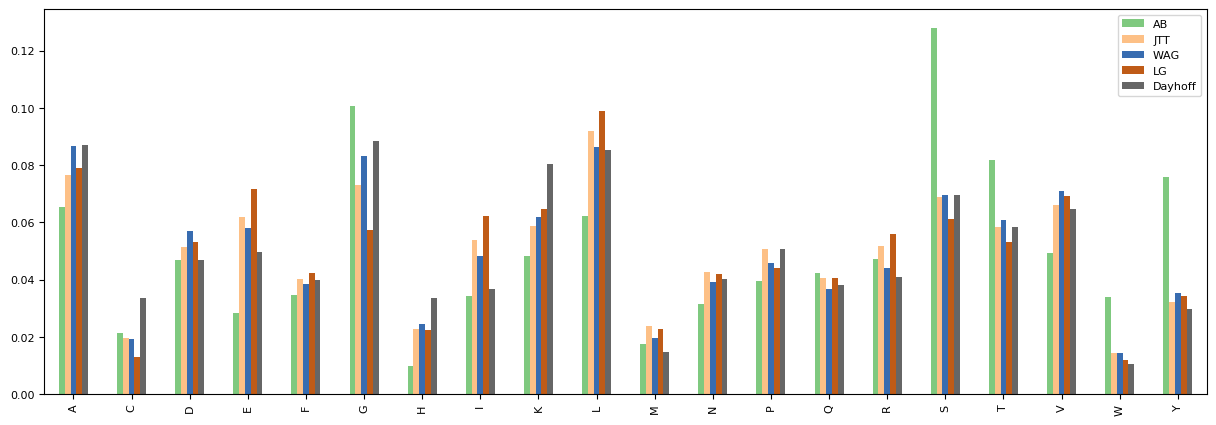

In [507]:
freq_df = pd.DataFrame()
for modelname in [ 'AB', 'JTT','WAG', 'LG','Dayhoff']:
    model = pyvolve.Model(modelname)
    freq_df[modelname] = pd.Series(model.extract_state_freqs(), index = model.code)
freq_df.plot.bar(colors = model_colors, figsize = (15,5))

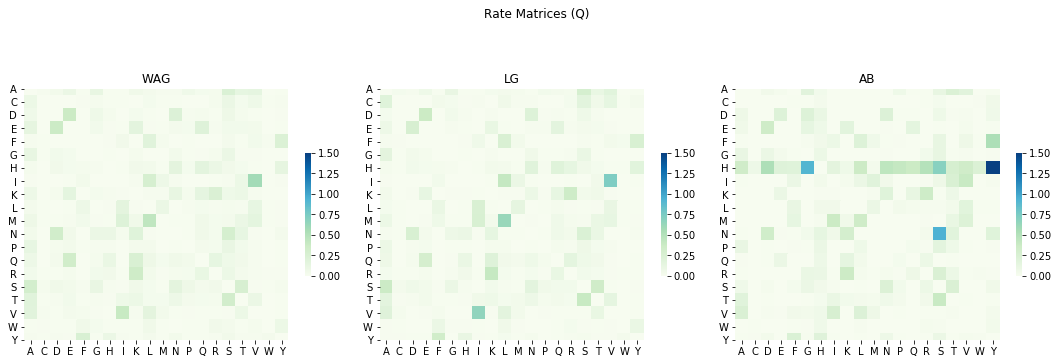

In [6]:
fig, axs = plt.subplots(1, 3, figsize =(15,6))
fig.suptitle('Rate Matrices (Q)')
for i, modelname in enumerate(['WAG', 'LG', 'AB']):
    model = pyvolve.Model(modelname)
    rate_matrix = copy.deepcopy(model.matrix)
    np.fill_diagonal(rate_matrix, 0)
    sns.heatmap(rate_matrix,cmap = 'GnBu', ax = axs[i], label  = modelname,
                xticklabels=model.code, square=True, cbar_kws={"shrink": .3}, vmax = 1.5 )
    axs[i].set_yticklabels(model.code, rotation = 'horizontal')
    axs[i].set_title(modelname)
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/Q-matrices.png', dpi = 300)

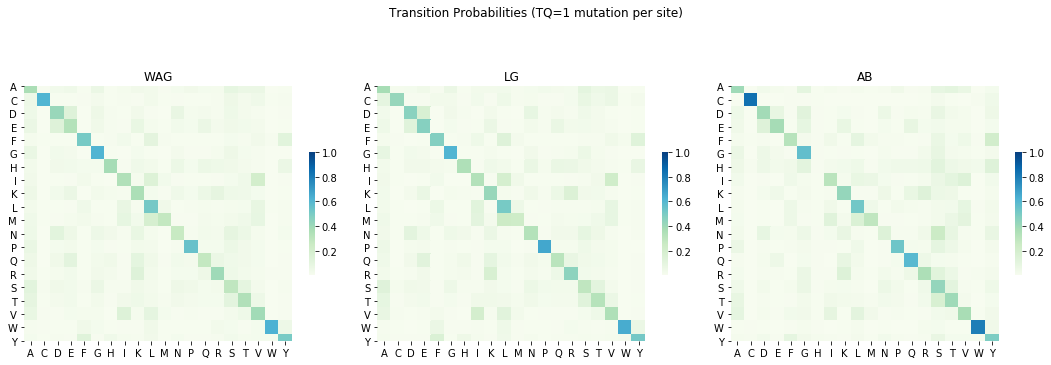

In [7]:
fig, axs = plt.subplots(1, 3, figsize =(15,6))
fig.suptitle('Transition Probabilities (TQ=1 mutation per site)')
for i, modelname in enumerate(['WAG', 'LG', 'AB']):
    model = pyvolve.Model(modelname)
    rate_matrix = copy.deepcopy(model.matrix)
    sns.heatmap(scipy.linalg.expm(rate_matrix),cmap = 'GnBu', ax = axs[i], label  = modelname,
                xticklabels=model.code,vmax = 1., square=True, cbar_kws={"shrink": .3} )
    axs[i].set_yticklabels(model.code, rotation = 'horizontal')
    axs[i].set_title(modelname)
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/P-matrices.png', dpi = 300)

## Delta Matrices for Amino acids

In [14]:
filename = '/Poppy/vbhardwaj/shm_project/aadelta_matrices.xlsx'

In [15]:
Delta = utils.delta_matrices(volume = utils.get_delta_matrix(filename, 'volume'), 
                       polarity = utils.get_delta_matrix(filename, 'polarity'), 
                       aromaticity = utils.get_delta_matrix(filename, 'aromaticity'),
                       composition = utils.get_delta_matrix(filename, 'composition'))

In [16]:
Delta

Delta matrices of sizes  
Volume      - (20, 20)
Polarity    - (20, 20)
Aromaticity - (20, 20)
Composition - (20, 20)

Rows and columns for Volume
Rows    = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

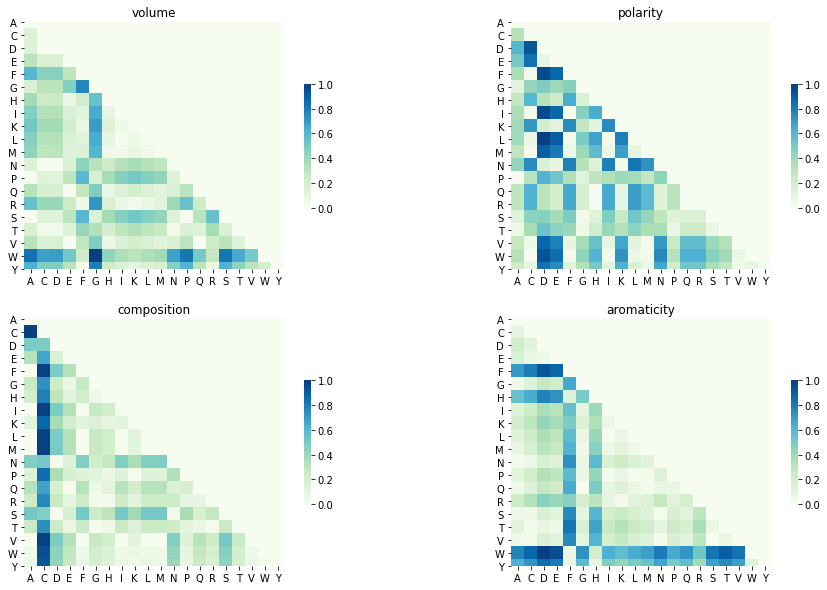

In [17]:
Delta.plot()

## For one clonal tree

In [690]:
importlib.reload(utils)

<module 'utils' from '/Poppy/vbhardwaj/shm_project/utils.py'>

### Simulations

In [691]:
CG_1615 = utils.clonal_graph(shm_file  = './Data/lineage1615_vertices30_shms.txt',
                             seqs_file = './Data/lineage1615_vertices30_seqs.txt')

In [389]:
delta_mean_df

,AB,JTT,WAG,LG,Dayhoff
volume,0.001887,0.001634,0.001642,0.001428,0.001544
polarity,0.001910,0.001722,0.001847,0.001573,0.001751
composition,0.001474,0.001512,0.001521,0.001335,0.001633
aromaticity,0.001940,0.001473,0.001529,0.001431,0.001417


In [390]:
%%time
#null_dist = {}
num_cores = 40
n_sim = 200
for model in [ 'LG', 'Dayhoff' ]:
    # Setup pyvolve model for simulations
    my_model = pyvolve.Model(model)
    my_partition = pyvolve.Partition(models = my_model, size = 120)
    my_evolver = pyvolve.Evolver(partitions = my_partition, tree = CG_1615.pyvolve_phylogeny)
    
    # Clear the simulated data already present and do new simulations
    CG_1615.simulations = []
    for i in range(n_sim):
        my_evolver(write_anc = True,
                   ratefile = None,
                   infofile =  None,
                   seqfile =None )
        simulated_seqs = my_evolver.get_sequences(anc = True)
        CG_1615.simulations.append(simulated_seqs)
    
    # Get null distribution from simulated data
    null_dist[model] = CG_1615.sims_to_null_dists_parallel( Delta, cpus=num_cores) 
    

CPU times: user 44.8 s, sys: 972 ms, total: 45.8 s
Wall time: 1min 15s


### Null distributions of different models

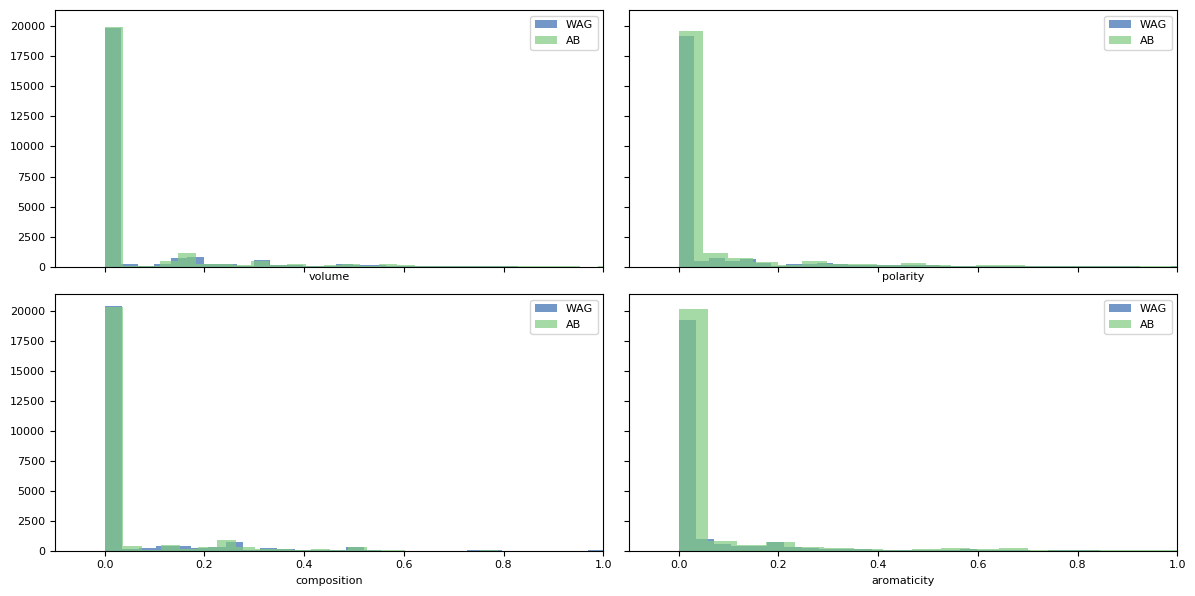

In [508]:
fig, axs = plt.subplots(2, 2, figsize = (12,6), sharex=True, sharey=True)
axs = axs.ravel()
for i, a_property in enumerate(['volume', 'polarity', 'composition', 'aromaticity']):
    
    sns.distplot(null_dist['WAG'].loc[a_property], ax = axs[i],label = 'WAG', color=model_colors[2], 
                 hist_kws={'alpha':0.7, 'density' : False} , kde = False, 
                 )
    sns.distplot(null_dist['AB'].loc[a_property], ax = axs[i], label = 'AB',  color=model_colors[0], 
                 hist_kws={'alpha':0.7, 'density' : False}, kde = False, 
                 )
    axs[i].set_xlim(-0.1, 1.0)
    axs[i].legend()
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/mull_dist.png', dpi = 300)

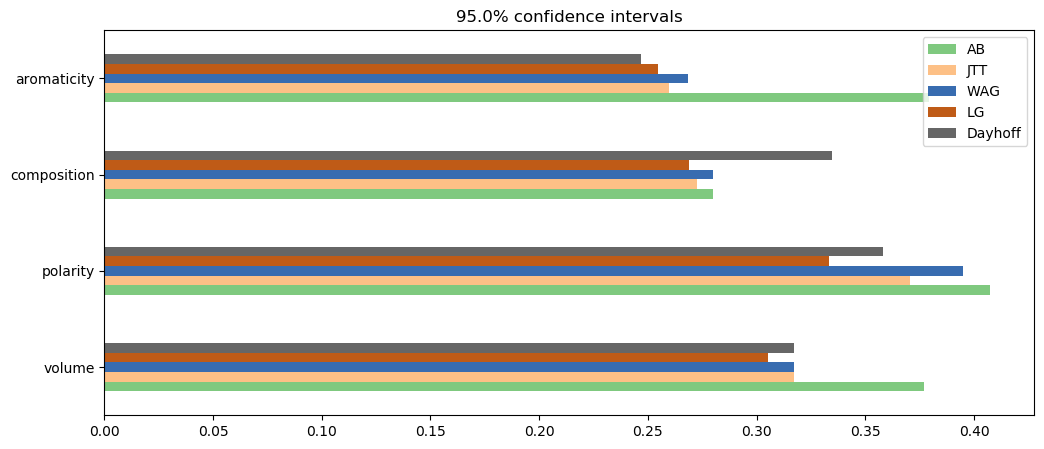

In [398]:
mpl.style.use('default')
Conf_int = utils.CI_from_null(null_dist, 0.95, )                             

### Observed test statistics

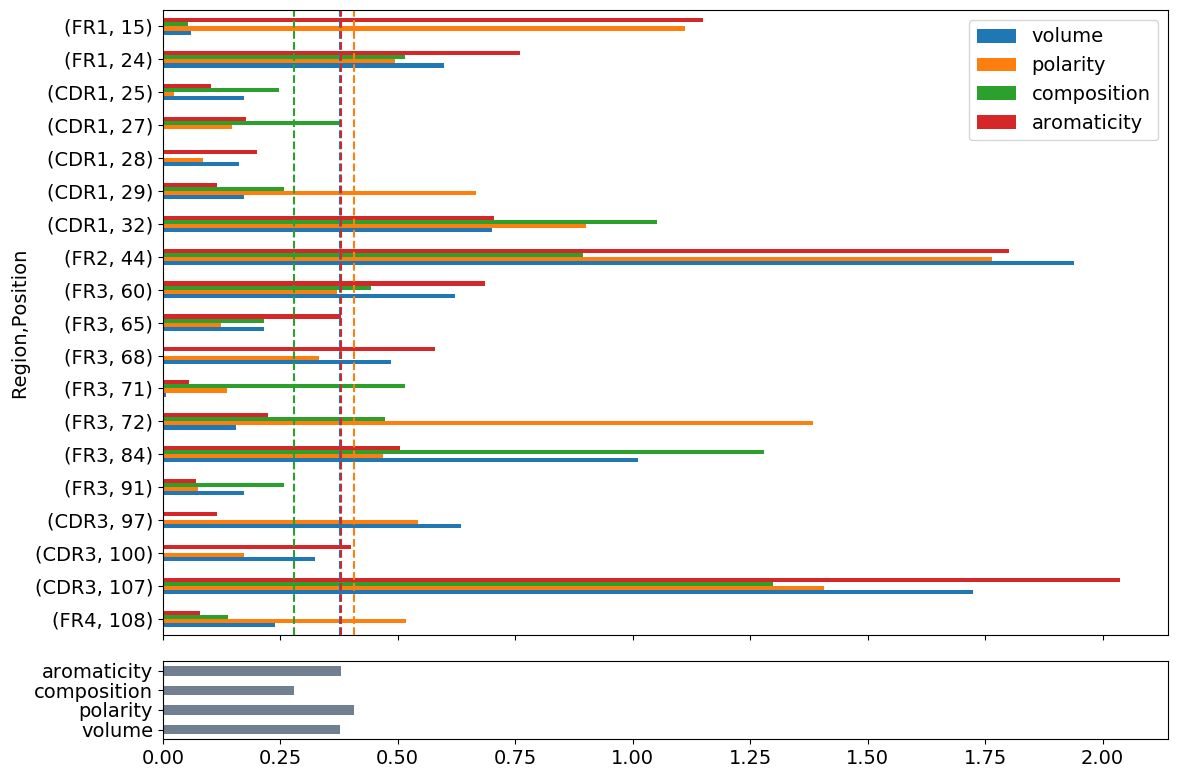

In [635]:
utils.plot_observed_stats(CG_1615, Delta, Conf_int, model = 'AB', )

In [56]:
output = utils.create_output_df(CG_1615, Delta, Conf_int, 'AB',)

### Expected Delta values - Empirical and Analytical

In [460]:
def get_analytical_mean_var(model,a_delta_matrices_instance,  time_scale =1/120):
    exp_delta = pd.Series()
    var_delta = pd.Series()
    
    my_model = pyvolve.Model(model)
    pi = np.diag(my_model.extract_state_freqs())
    rate_matrix = my_model.extract_rate_matrix()
    transition_probs= scipy.linalg.expm(time_scale*rate_matrix)
    joint_probs = np.array((pi@transition_probs)).ravel()
    for a_property in ['volume', 'polarity', 'composition', 'aromaticity']:
        delta = np.array(getattr(a_delta_matrices_instance, a_property)).ravel()
        mean = joint_probs.dot(delta)
        exp_delta.loc[a_property] = mean
        var_delta.loc[a_property] = joint_probs.dot((delta - mean)**2)
    return exp_delta, var_delta

In [461]:
analytical_mean_df = pd.DataFrame()
analytical_var_df = pd.DataFrame()
for model in [ 'AB', 'JTT','WAG', 'LG','Dayhoff']:
    analytical_mean_df[model],analytical_var_df[model] = get_analytical_mean_var(model,Delta)

In [462]:
empirical_mean = pd.DataFrame()
empirical_var = pd.DataFrame()
for model in null_dist:
    empirical_mean[model] = null_dist[model].apply(lambda x : np.mean(x), 1, )
    empirical_var[model] = null_dist[model].apply(lambda x : np.var(x), 1, )


In [503]:
model_colors= [mpl.cm.get_cmap('Accent').colors[i] for i in [0,2,4,6,7,1,3,5]]

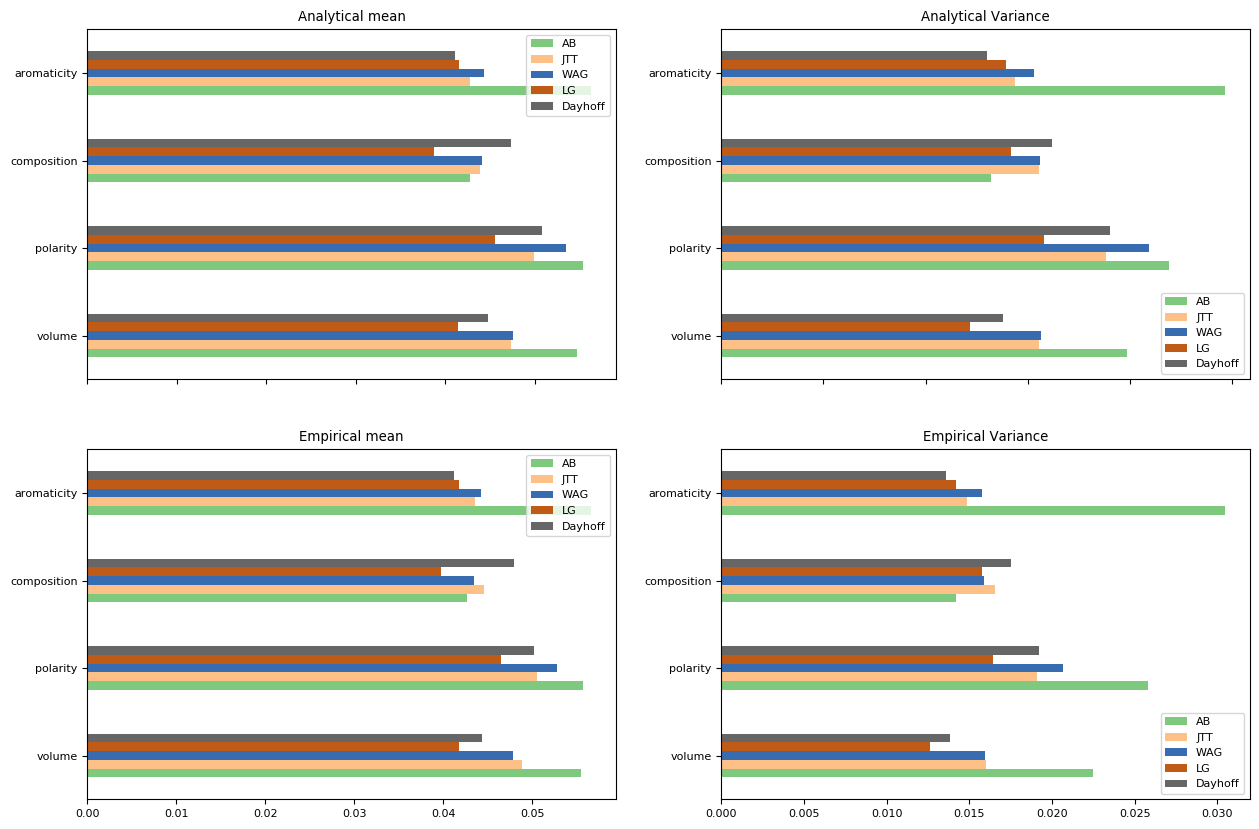

In [504]:
mpl.rcParams.update({'font.size':8})
fig, axs = plt.subplots(2, 2 ,figsize = (15,10))
axs = axs.ravel()

(29*analytical_mean_df).plot.barh(, colors = model_colors, ax = axs[0], );
axs[0].set_title(f'Analytical mean');

(29*analytical_var_df).plot.barh(colors = model_colors, ax = axs[1]);
axs[1].set_title(f'Analytical Variance');

empirical_mean.plot.barh(colors = model_colors, ax = axs[2], sharex = axs[0]);
axs[2].set_title(f'Empirical mean');

empirical_var.plot.barh(colors = model_colors, ax = axs[3], sharex = axs[1]);
axs[3].set_title(f'Empirical Variance');

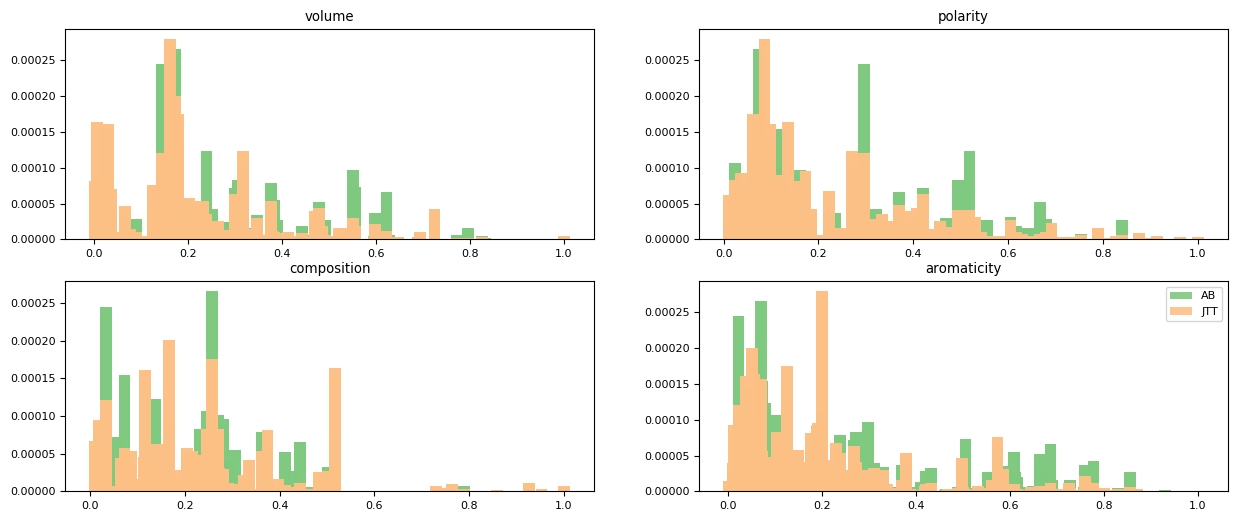

In [505]:

fig, axs = plt.subplots(2,2, figsize = (15, 6))
for j, model in enumerate(['AB', 'JTT']):
    my_model = pyvolve.Model(model)
    pi = np.diag(my_model.extract_state_freqs())
    rate_matrix = my_model.extract_rate_matrix()
    transition_probs= scipy.linalg.expm(1/120*rate_matrix)
    joint_probs = np.array((pi@transition_probs)).ravel()
   
    axs = axs.ravel()
    for i, a_property in enumerate(['volume', 'polarity', 'composition', 'aromaticity']):
        delta = np.array(getattr(Delta, a_property)).ravel()
        axs[i].bar(x = delta[delta>0], height = joint_probs[delta>0], alpha  =0.9, 
                   width = 0.025, color = model_colors[j], label  = model)
        axs[i].set_title(a_property)
plt.legend();

### Leaves vs Internal distributions

In [ ]:
def plot_stats_mutations(A_Clone):
    stats_leaves = A_Clone.get_observed_stats(Delta, which_edges='leaves', return_mean_stats=True)
    stats_internal = A_Clone.get_observed_stats(Delta, which_edges='internal', return_mean_stats=True)
    stats_internal.sort_values([('Position')], inplace=True, ascending=False)
    stats_leaves.sort_values([('Position')], inplace=True, ascending=False)
    mutations_leaves = A_Clone.get_observed_mutations( which_edges='leaves')
    mutations_internal = A_Clone.get_observed_mutations( which_edges='internal')

    with plt.rc_context({'font.size': 10}):
        # Set up plotting
        fig, axs = plt.subplots(2, 2, figsize =( 12, 10), sharey = True)
        axs = axs.ravel()

        # Subplot 1
        stats_leaves[['volume', 'polarity', 'composition', 'aromaticity']].plot.barh(colors = property_colors, ax = axs[0])
        axs[0].invert_xaxis()
        axs[0].set_title('Leaves')

        stats_internal[['volume', 'polarity', 'composition', 'aromaticity']].plot.barh(colors = property_colors, ax = axs[1])
        axs[1].set_title('internal')

        # Subplot 1
        mutations_leaves.plot.barh(colors = property_colors, ax = axs[2])
        axs[2].invert_xaxis()
        axs[2].set_title('Leaves')

        mutations_internal.plot.barh(colors = property_colors, ax = axs[3])
        axs[3].set_title('internal')
        plt.subplots_adjust(wspace=0.05,)
    name = A_Clone.shm_file.split('/')[-1].split('_')[0]
    plt.savefig(os.path.join('../shm_project/images/Explore/', name+ '.png'), dpi = 300)

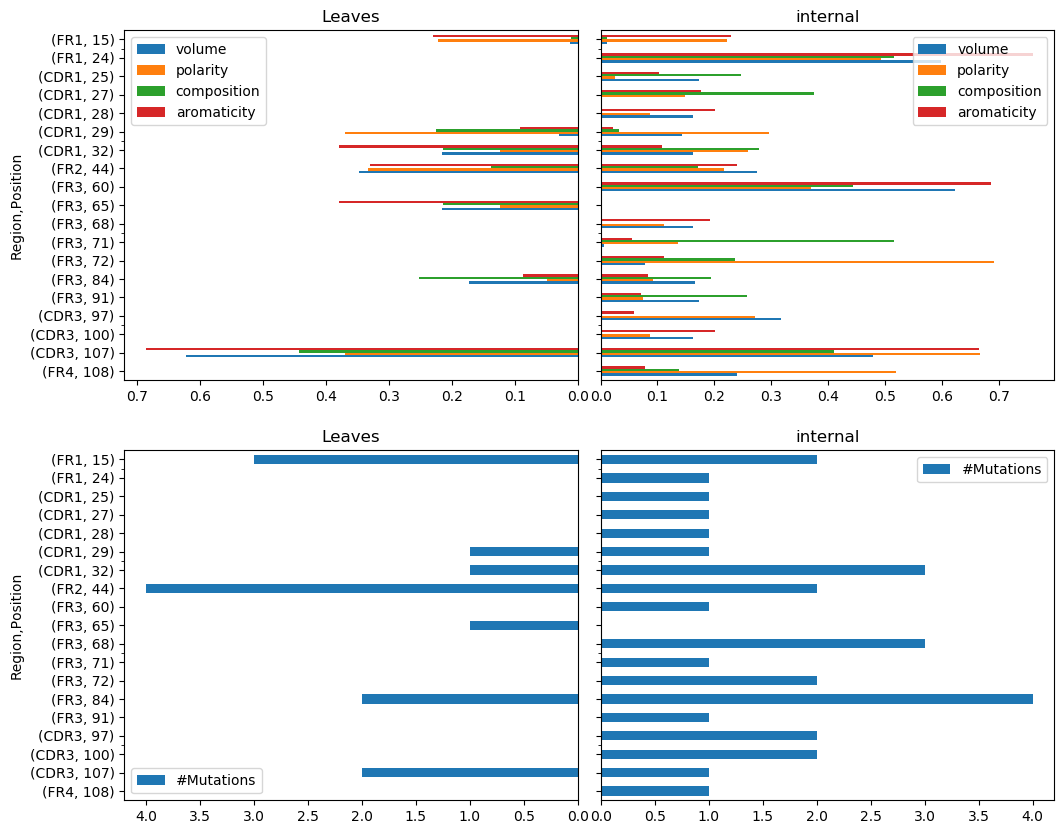

In [692]:
plot_stats_mutations(CG_1615)

In [693]:
CG_1615.nodes

{'Node11a': Name                                Node11a
 V-gene                        IGHV4-30-4*01
 J_gene                             IGHJ4*02
 Nucleotide sequence Counts            267,7
 dtype: object, 'Node2a': Name                                 Node2a
 V-gene                        IGHV4-30-4*01
 J_gene                             IGHJ4*02
 Nucleotide sequence Counts                5
 dtype: object, 'Node25a': Name                                Node25a
 V-gene                        IGHV4-30-4*01
 J_gene                             IGHJ4*02
 Nucleotide sequence Counts                4
 dtype: object, 'Node3a': Name                                 Node3a
 V-gene                        IGHV4-30-4*01
 J_gene                             IGHJ4*02
 Nucleotide sequence Counts                5
 dtype: object, 'Node16a': Name                                Node16a
 V-gene                        IGHV4-30-4*01
 J_gene                             IGHJ4*02
 Nucleotide sequence Counts     